# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


<div class="paragraph">Предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой <em>Bootstrap.</em></div>

<h2>Описание данных</h2><div class="paragraph">Данные геологоразведки трёх регионов находятся в файлах: </div>
<ul>
    <li><code class="code-inline code-inline_theme_light">/datasets/geo_data_0.csv</code>.</li>
    <li><code class="code-inline code-inline_theme_light">/datasets/geo_data_1.csv</code>.</li>
    <li><code class="code-inline code-inline_theme_light">/datasets/geo_data_2.csv</code>.</li>
    <li><em>id</em> — уникальный идентификатор скважины;</li>
    <li><em>f0, f1, f2</em> — три признака точек (неважно, что они означают, но сами признаки значимы);</li>
    <li><em>product</em> — объём запасов в скважине (тыс. баррелей).</li>
</ul>

<div class="paragraph"><strong>Условия задачи:</strong></div>
<ul>
    <li>Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).</li>
    <li>При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.</li><li>Бюджет на разработку скважин в регионе — 10 млрд рублей.</li>
    <li>При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.</li>
    <li>После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.</li>
</ul>

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.stats import t
from numpy.random import RandomState


rcParams['figure.figsize'] = (9, 6)

pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_columns = 100
pd.set_option('display.max_rows', 50)
pd.options.mode.chained_assignment = None

plt.rcParams['image.cmap'] = 'Set2'
plt.set_cmap("Set2");

sns.set_style("whitegrid", {'figure.facecolor': '0.97'});
sns.set_palette("Set2");

<Figure size 648x432 with 0 Axes>

In [2]:
# сделаем треугольную матрицу heatmap без диагональных элементов
def corr_triag_heatmap(corr, title_str):
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    mask = np.triu(np.full(corr.shape, True))
    corr = corr.iloc[1:, :-1]
    mask = pd.DataFrame(mask).iloc[1:, :-1].to_numpy()

    # делаем heatmap
    plt.figure(figsize=(corr.shape[0] * 1.2, (corr.shape[0] * 0.6)))
    ax = sns.heatmap(corr, annot=True, cmap="RdBu", mask=mask, vmin=-1, vmax=1)
    ax.set_title(title_str, fontdict={'fontsize':14})
    plt.show()

# Определим функцию для изучения датасета, ее будем применять к разным датафреймам
def evaluate_df(df, show_corr_zero_plots = False):
    print('\n------SAMPLE--------')
    display(df.sample(min(5,len(df))))
    print('\n------DTYPES--------')
    print(df.dtypes)

    # число пропусков
    print('\n\n------NaN & zero--------')
    na = pd.DataFrame(index=df.columns
                      , data={
                          'NA':df.isna().sum().values
                          , 'filled': df.notna().sum().values
                          , 'zero':df.isin([0,'0']).sum()
                      }
                     )
    na['%na'] = na['NA']/len(df)*100
    print(na.replace(0,'-'))
    
    if show_corr_zero_plots:
        # готовим матрицу корреляций нулей
        t = df.isin([0,'0']).sum().sort_values()
        indx = t[t > 0].index
        if len(indx) > 0:
            print()
            corr = df[indx].isin([0,'0']).corr()
            corr_triag_heatmap(corr, "Correlation of ZEROs in columns")
            
            # Добавим карту синхронных нулей
            t = df[indx].isin([0,'0']).sort_values(by=list(indx))
            plt.figure(figsize = (20,len(indx)*0.6))
            
            ax = sns.heatmap(t.transpose(), alpha=0.4,cbar_kws = {"ticks":[False, True], "drawedges":True}, cmap=sns.color_palette(['#00AA00', '#FF4444']))
            ax.set_title("Map of ZEROs values", fontdict={'fontsize':14})
            ax.hlines(ax.yaxis.get_ticklocs() + 0.5, 0, t.shape[0], color='w', linewidths=1)
            plt.show()

    # статистики
    display(df.describe(include='all').transpose())
    
    pd.plotting.scatter_matrix(df, figsize=(16,10), alpha=0.1, s=5);

def show_dependency(df):
    figure = plt.figure(figsize=(9,18))
    ax = plt.subplot(3,1, 1)
    sns.scatterplot( x='f0', y='f1', data=df, hue='product'
                    , alpha=0.2
                    , edgecolor = 'none'
                    , s=5
                    , ax = ax
    );
    ax = plt.subplot(3,1, 2)
    sns.scatterplot( x='f0', y='f2', data=df, hue='product'
                    , alpha=0.2
                    , edgecolor = 'none'
                    , s=5
                    , ax = ax
    );
    ax = plt.subplot(3,1, 3)
    sns.scatterplot( x='f1', y='f2', data=df, hue='product'
                    , alpha=0.2
                    , edgecolor = 'none'
                    , s=5
                    , ax = ax
    );

In [3]:
try:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')
except:
    df_0 = pd.read_csv('datasets\yandex_08_geo_data_0.csv', sep=',')
    df_1 = pd.read_csv('datasets\yandex_08_geo_data_1.csv', sep=',')
    df_2 = pd.read_csv('datasets\yandex_08_geo_data_2.csv', sep=',')


# df_all = [[df_0, df_1, df_2], ['dataset #0', 'dataset #1', 'dataset #2']]
df_all = {'Region #0': df_0, 'Region #1': df_1, 'Region #2': df_2}


------SAMPLE--------


id    f0     f1     f2  product
62873  uwDU6 0.552 -0.531 -0.913   75.675
23958  d1Xcd 1.743  0.037  4.350  170.745
55669  r6Avb 0.829  0.002  2.481   58.560
58186  jJ2Lo 0.956  0.088  1.976   91.662
27002  deP0d 0.304  1.043  2.261  122.964


------DTYPES--------
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


------NaN & zero--------
        NA  filled zero %na
id       -  100000    -   -
f0       -  100000    -   -
f1       -  100000    -   -
f2       -  100000    -   -
product  -  100000    1   -


count unique    top freq   mean    std     min    25%    50%  \
id           100000  99990  AGS9W    2    NaN    NaN     NaN    NaN    NaN   
f0      100,000.000    NaN    NaN  NaN  0.500  0.872  -1.409 -0.073  0.502   
f1      100,000.000    NaN    NaN  NaN  0.250  0.504  -0.848 -0.201  0.250   
f2      100,000.000    NaN    NaN  NaN  2.503  3.248 -12.088  0.288  2.516   
product 100,000.000    NaN    NaN  NaN 92.500 44.289   0.000 56.498 91.850   

            75%     max  
id          NaN     NaN  
f0        1.074   2.362  
f1        0.701   1.344  
f2        4.715  16.004  
product 128.564 185.364

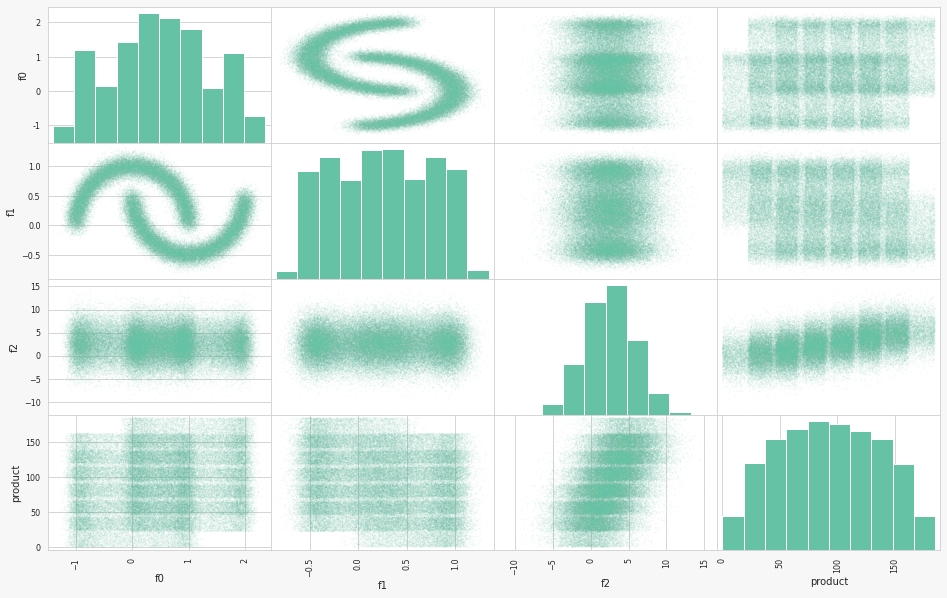

In [4]:
evaluate_df(df_0, False)

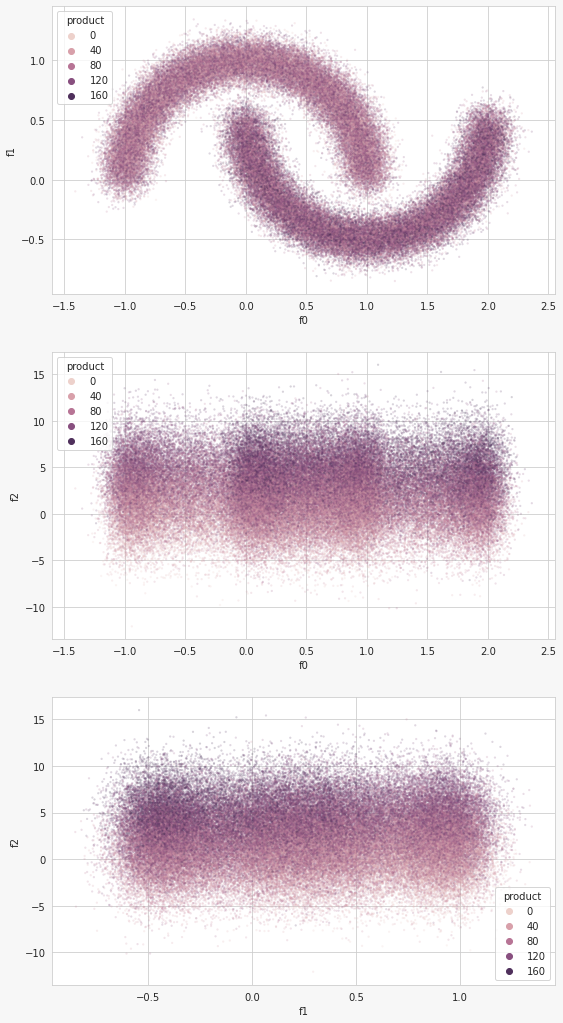

In [5]:
show_dependency(df_0)


------SAMPLE--------


id      f0      f1     f2  product
94012  DbCNl  -6.715  -5.544 -0.005    3.179
48835  uLXX2   3.984  -5.828  4.012  107.813
19558  GJqI9  10.556  -8.393  0.990   26.953
24309  3QoAQ -15.823 -16.303  0.006    3.179
31121  TZex9   1.239 -10.176  2.997   80.860


------DTYPES--------
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


------NaN & zero--------
        NA  filled  zero %na
id       -  100000     -   -
f0       -  100000     -   -
f1       -  100000     -   -
f2       -  100000     -   -
product  -  100000  8235   -


count unique    top freq   mean    std     min    25%    50%  \
id           100000  99996  wt4Uk    2    NaN    NaN     NaN    NaN    NaN   
f0      100,000.000    NaN    NaN  NaN  1.141  8.966 -31.610 -6.299  1.153   
f1      100,000.000    NaN    NaN  NaN -4.797  5.120 -26.359 -8.268 -4.813   
f2      100,000.000    NaN    NaN  NaN  2.495  1.704  -0.018  1.000  2.011   
product 100,000.000    NaN    NaN  NaN 68.825 45.944   0.000 26.953 57.086   

            75%     max  
id          NaN     NaN  
f0        8.621  29.422  
f1       -1.333  18.734  
f2        4.000   5.020  
product 107.813 137.945

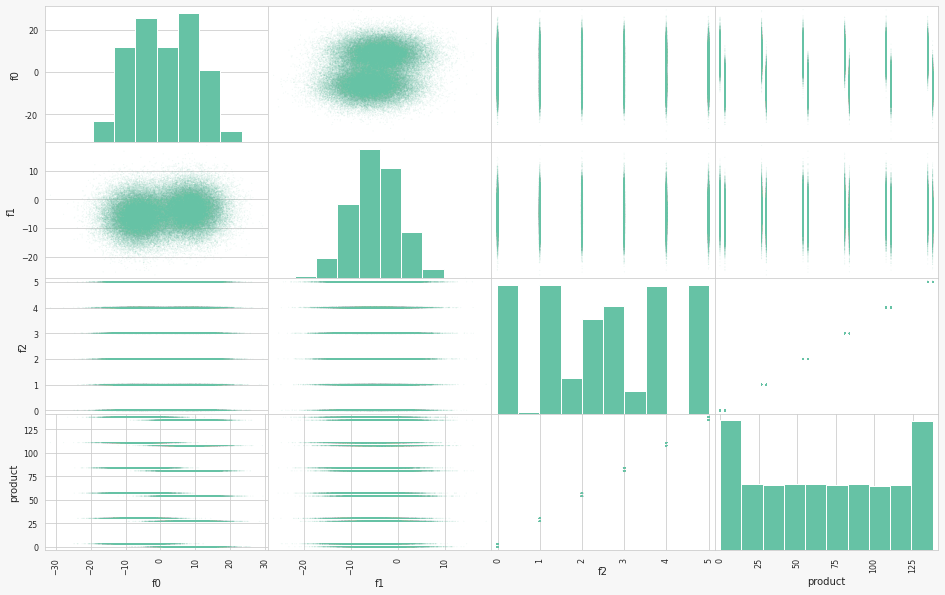

In [6]:
evaluate_df(df_1, False)

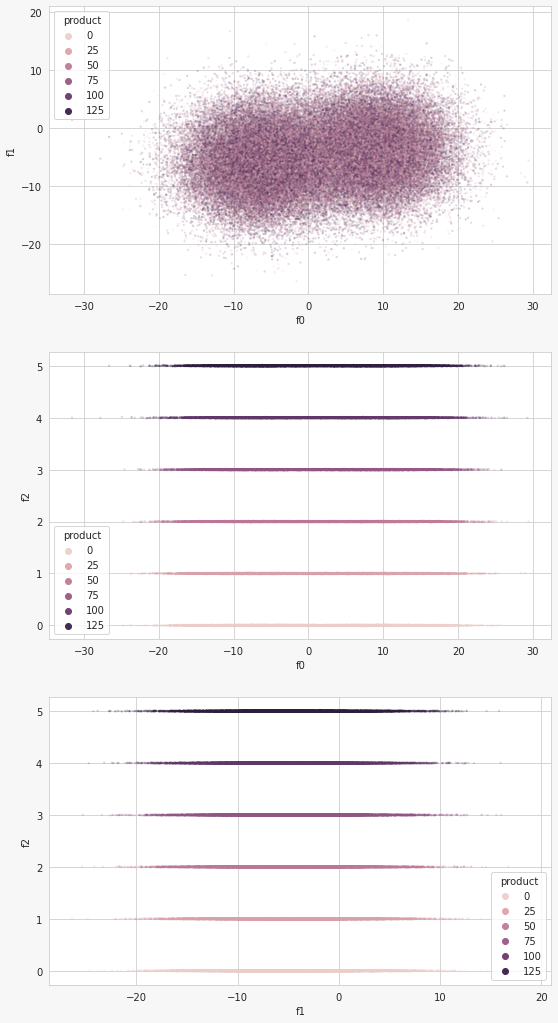

In [7]:
show_dependency(df_1)


------SAMPLE--------


id     f0     f1    f2  product
88703  0LJZ9  0.727  0.672 5.228   77.774
56665  OYoHo  0.309  2.752 3.452  105.871
1906   pQrQl  0.407 -2.892 1.196   69.354
19424  7xmTa -1.710 -1.540 2.106   40.209
67583  1dMqh  0.406  2.299 1.888   85.215


------DTYPES--------
id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


------NaN & zero--------
        NA  filled zero %na
id       -  100000    -   -
f0       -  100000    -   -
f1       -  100000    -   -
f2       -  100000    -   -
product  -  100000    1   -


count unique    top freq   mean    std     min    25%    50%  \
id           100000  99996  KUPhW    2    NaN    NaN     NaN    NaN    NaN   
f0      100,000.000    NaN    NaN  NaN  0.002  1.732  -8.760 -1.162  0.009   
f1      100,000.000    NaN    NaN  NaN -0.002  1.730  -7.084 -1.175 -0.009   
f2      100,000.000    NaN    NaN  NaN  2.495  3.473 -11.970  0.130  2.484   
product 100,000.000    NaN    NaN  NaN 95.000 44.750   0.000 59.450 94.926   

            75%     max  
id          NaN     NaN  
f0        1.159   7.238  
f1        1.164   7.845  
f2        4.859  16.739  
product 130.595 190.030

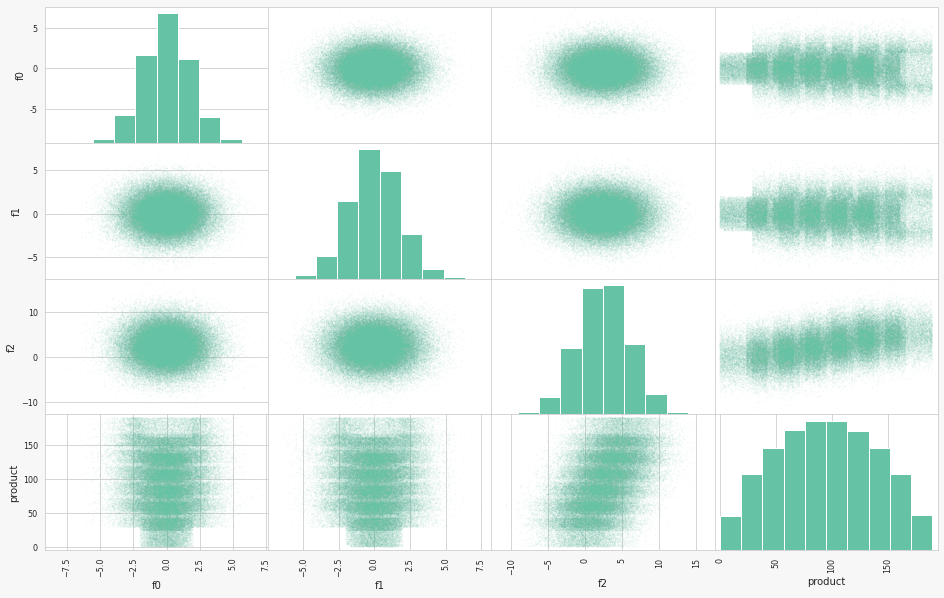

In [8]:
evaluate_df(df_2, False)

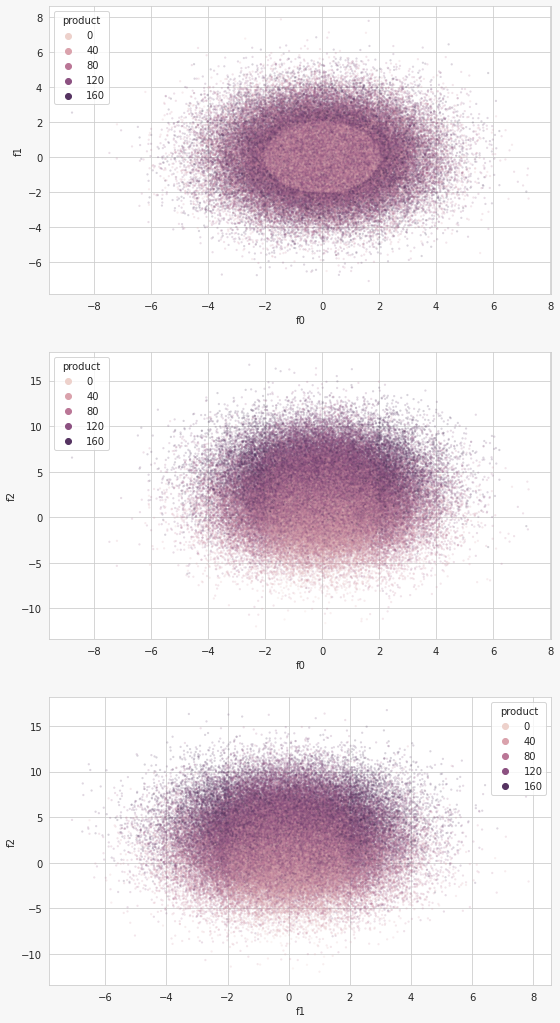

In [9]:
show_dependency(df_2)

Построим 3D точечные диаграммы, разметив цветом product

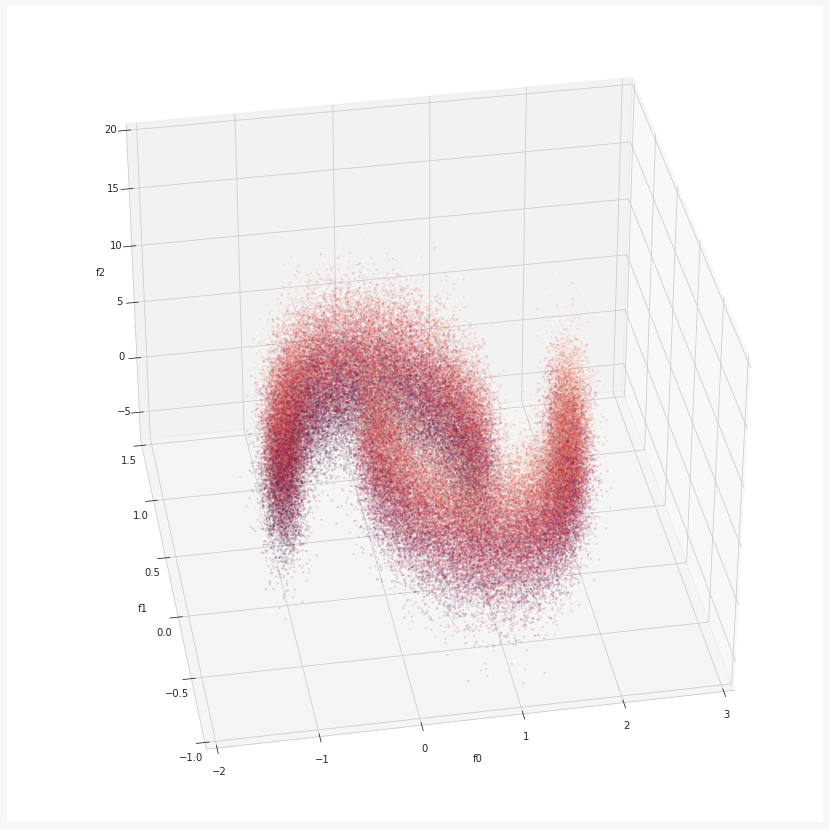

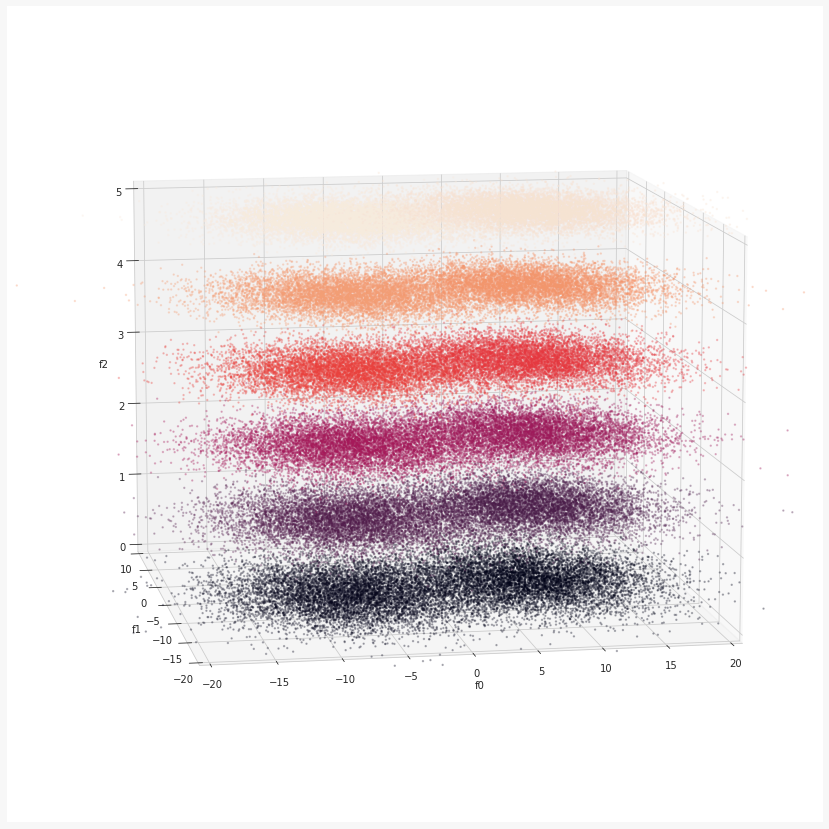

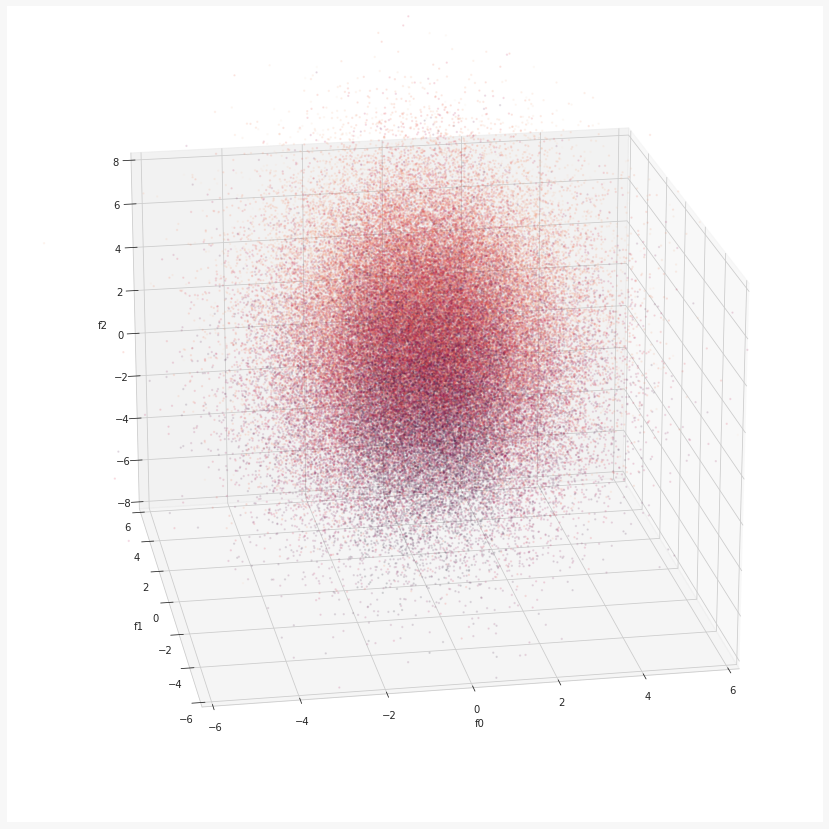

In [10]:
def make_3d(df, alpha, elev, azim, xlim, ylim, zlim):
    fig = plt.figure(figsize=(15, 15))

    ax = fig.add_subplot(projection='3d', azim=azim, elev=elev)
    ax.scatter3D(df['f0'], df['f1'], df['f2']
                 , s=2
                 , alpha=alpha
                 , c=df['product']
              )
    ax.set(xlabel='f0', ylabel='f1', zlabel='f2', xlim=xlim, ylim=ylim, zlim=zlim)
    plt.show()


make_3d(df_0, alpha=0.1, elev=35, azim=-100, xlim=(-2, 3), ylim=(-1, 1.5), zlim=(-7, 20))
make_3d(df_1, alpha=0.25, elev=10, azim=-100, xlim=(-20, 20), ylim=(-20, 10), zlim=(0, 5))
make_3d(df_2, 0.1, 20, -100, xlim=(-6, 6), ylim=(-6, 6), zlim=(-8, 8))

Делим на тренировочную и проверочную выборки в соотношении 3:1

In [11]:
def split_df(df):
    y = df['product']
    X = df.drop(['product', 'id'], axis=1)
    X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.25
                                                          , shuffle=True
                                                          , random_state=12345)
    # Вспомогательный массив
    splitted_sets = {'TRAIN':{"X":X_train, 'y':y_train}, 'VALID':{'X':X_valid, 'y':y_valid}}
    sh_df = pd.DataFrame(data = {
        'subset':['TRAIN', 'VALID']
        , 'X_shape':[splitted_sets['TRAIN']['X'].shape, splitted_sets['VALID']['X'].shape]
        , 'y_shape':[splitted_sets['TRAIN']['y'].shape, splitted_sets['VALID']['y'].shape]
        , 'y_mean':[splitted_sets['TRAIN']['y'].mean(), splitted_sets['VALID']['y'].mean()]
    })
    display(sh_df.set_index('subset'))
    return X_train, X_valid, y_train, y_valid

### Выводы

Данные без пропусков, не требуют очистки
Исследуемые признаки имеют разный масштаб, что для LinearRegression критично. Нужно будет масштабировать их.

<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены и осмотрены корректно. Согласен, что колонка id нам не нужна. Визуализация получилась хорошо.
</div>

## Обучение и проверка модели

In [12]:
def create_model(X_train, X_valid, y_train, y_valid):
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train_scaled, y_train)
    predictions_valid = model.predict(X_valid_scaled)
    rmse = mean_squared_error(y_valid, predictions_valid)**0.5
    return rmse, model.score(X_valid_scaled, y_valid), predictions_valid



====   Calculate Region #0   ====

shapes after splitting


X_shape   y_shape  y_mean
subset                              
TRAIN   (75000, 3)  (75000,)  92.640
VALID   (25000, 3)  (25000,)  92.079

Results on validation subset
RMSE = 37.58
R2 = 0.2799
predictions mean and std: 92.59 and 23.18
target mean and std: 92.08 and 44.29

 -----PLOT predict VS target -----


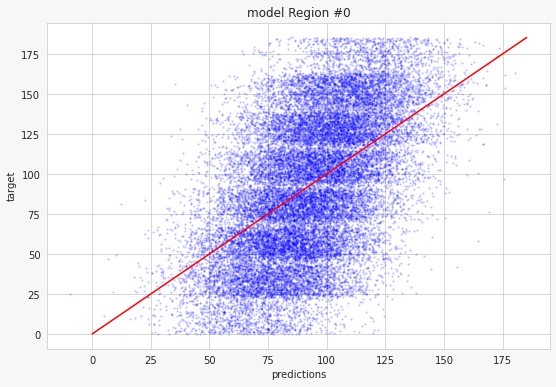




====   Calculate Region #1   ====

shapes after splitting


X_shape   y_shape  y_mean
subset                              
TRAIN   (75000, 3)  (75000,)  68.859
VALID   (25000, 3)  (25000,)  68.723

Results on validation subset
RMSE = 0.89
R2 = 0.9996
predictions mean and std: 68.73 and 46.01
target mean and std: 68.72 and 46.02

 -----PLOT predict VS target -----


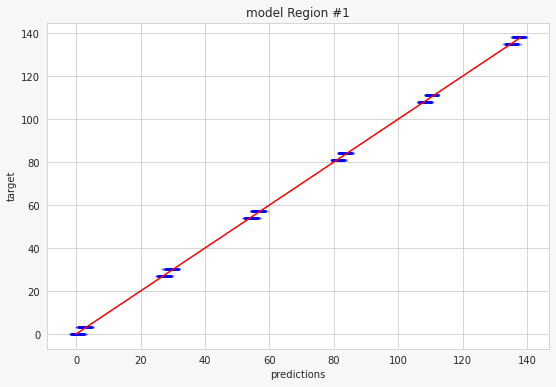




====   Calculate Region #2   ====

shapes after splitting


X_shape   y_shape  y_mean
subset                              
TRAIN   (75000, 3)  (75000,)  95.039
VALID   (25000, 3)  (25000,)  94.884

Results on validation subset
RMSE = 40.03
R2 = 0.2052
predictions mean and std: 94.97 and 19.85
target mean and std: 94.88 and 44.90

 -----PLOT predict VS target -----


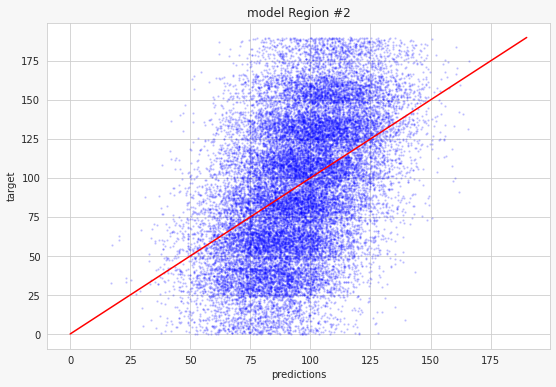

In [13]:
results = []
for name, df in df_all.items():
    print(f'\n\n====   Calculate {name}   ====\n')
    print('shapes after splitting')
    X_train, X_valid, y_train, y_valid = split_df(df)
    rmse, r2, predictions_valid = create_model(X_train, X_valid, y_train, y_valid)
    print('Results on validation subset')
    print(f'RMSE = {rmse:.2f}')
    print(f'R2 = {r2:.4f}')
    print(f'predictions mean and std: {predictions_valid.mean():.2f} and {predictions_valid.std():.2f}')
    print(f'target mean and std: {y_valid.mean():.2f} and {y_valid.std():.2f}')

    print('\n -----PLOT predict VS target -----')
    plt.scatter(predictions_valid, y_valid, s=2, alpha=0.15, c='b')
    plt.plot([0, y_valid.max()], [0, y_valid.max()], c='r')
    plt.xlabel('predictions')
    plt.ylabel('target')
    plt.title('model ' + name)
    plt.show()
    print()
    results.append([pd.Series(predictions_valid), y_valid.reset_index(drop=True)])

### Выводы
- Модели на 0 и 2 регионах дают скошенную оценку:  при низких прогнозах, прогноз получается завышенным, а при высоких прогнозах, прогноз занижен. Вообще такое надо бы устранить, но в нашем случае нам нужна прямая зависимость: бо'льшему target соответствует бо'льший predict, а это выполняется.
- Модель регионе №1 практически идеально прогнозирует. Но среднее у этого региона 68 против 92-95 у регионов 0 и 2.

<div class="alert alert-block alert-success">
<b>Успех:</b> Модели обучены корректно. Радует, что ты активно используешь циклы. Это помогает избежать дублирования кода, а значит уменьшает вероятность совершить ошибку/опечатку!
</div>

## Подготовка к расчёту прибыли

In [14]:
sample_research_size = 500
sample_selected_size = 200
total_expenses = 10e6  # в тыс руб
price_of_unit = 450
critical_loss_probability = 0.025

Объём сырья, достаточный для безубыточной разработки новой скважины

In [15]:
necessary_min_product = total_expenses / sample_selected_size / price_of_unit
print(f"Уровень безубыточности скважины: {necessary_min_product:.2f}")

Уровень безубыточности скважины: 111.11


In [16]:

for name, df in df_all.items():
    print(f'Mean product in {name}: {df["product"].mean():.3f}')
    
# print(df_0['product'].mean(), df_1['product'].mean(), df_2['product'].mean(), sep='\n')

Mean product in Region #0: 92.500
Mean product in Region #1: 68.825
Mean product in Region #2: 95.000


### Выводы

Требуемый объем сырья для безубыточности 111 существенно превышает средние уровни запасов по регионам.

<div class="alert alert-block alert-info">

<b>Совет: </b> В названиях константных переменных лучше использовать только БОЛЬШИЕ буквы. Это соглашение между программистами: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#id29 .
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Точка безубыточности найдена верно, сравнение проведено!
</div>

## Расчёт прибыли и рисков 

In [17]:
# Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def calc_profit_old(predictions, actual):
    indexes = predictions.sort_values(ascending=False)[:sample_selected_size].index
#     print(actual[indexes].shape, predictions.shape, actual.shape)
    return round(actual[indexes].sum() * price_of_unit - total_expenses, 2)

# Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели
def calc_profit(predictions, actual):
    t = pd.DataFrame(zip(predictions, actual), columns = ['predictions', 'actual'])
    s = t.sort_values(by=['predictions'], ascending=False).head(sample_selected_size)['actual'].sum()
    return round(s * price_of_unit - total_expenses, 2)

### BOOTSTRAP

In [18]:
state = RandomState(12345)
profits = []
for j in range(3):
    print("\n\nРегион", j)
    profit = []
    predictions = results[j][0]
    y_valid = results[j][1]
    for i in range(1000):
        y_subsample = y_valid.sample(n=sample_research_size, replace=True, random_state=state)
        predictions_subsample = predictions[y_subsample.index]
        profit.append(calc_profit(predictions_subsample, y_subsample))
    profit = pd.Series(profit)
    profits.append(profit)
    print(f"Средняя прибыль: {profit.mean():,.2f}")
#     confidence_interval = t.interval(alpha=0.95, df=len(profit) - 1, loc=profit.mean(), scale=profit.sem())
    confidence_interval = [profit.quantile(0.025), profit.quantile(0.975)]
    print(f'Доверительный интервал: ({confidence_interval[0]:,.2f}, {confidence_interval[1]:,.2f})')
#     loss_prob = len(profit[profit < 0]) / len(profit)
    loss_prob = (profit < 0).mean()
    if loss_prob < critical_loss_probability:
        conclusion = "\nУСПЕХ !!! вероятность убытков ниже критической"
    else:
        conclusion = "\nНЕУДАЧА :( вероятность убытков выше критической"
    print(f"Вероятность убытков: {loss_prob:.2%} {conclusion}")



Регион 0
Средняя прибыль: 396,164.98
Доверительный интервал: (-111,215.54, 909,766.95)
Вероятность убытков: 6.90% 
НЕУДАЧА :( вероятность убытков выше критической


Регион 1
Средняя прибыль: 461,155.82
Доверительный интервал: (78,050.82, 862,952.06)
Вероятность убытков: 0.70% 
УСПЕХ !!! вероятность убытков ниже критической


Регион 2
Средняя прибыль: 392,950.48
Доверительный интервал: (-112,227.63, 934,562.91)
Вероятность убытков: 6.50% 
НЕУДАЧА :( вероятность убытков выше критической


Построим еще гистограммы "доходности 200 скважин из 500 исследуемых" для разных районов

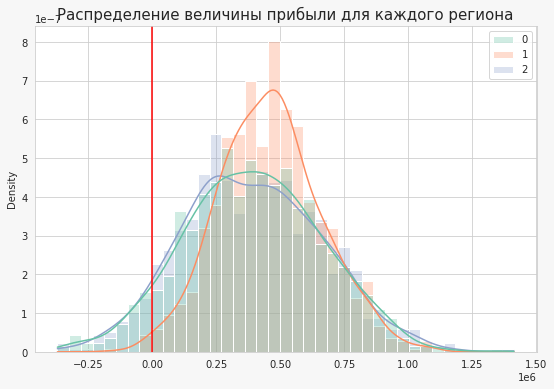

In [19]:
dfr = pd.DataFrame(zip(profits[0], profits[1], profits[2]))
sns.histplot(dfr, kde=True, stat='density', alpha=0.3)
plt.axvline(0, c="r")
plt.title('Распределение величины прибыли для каждого региона', fontsize=15)
plt.show()

### Вывод

Критерию "вероятность убытков ниже 2.5%" отвечает только Регион 1



## Итоговый вывод

В рамках проекта мы изучили три района и с помощью техники bootstrap оценили вероятность убытков на каждом из участков при бурении 200 скважин из изучаемых 500. В итоге был выбран участок #1 как достаточно надежный и максимально прибыльный, вероятность убытков на нем менее 1%, а доверительный 95% интервал прибыли (78,050.82, 862,952.06) при инвестициях 10 000 000 тыс. руб.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован